<a href="https://colab.research.google.com/github/george-kan/fastai/blob/main/Chapter5/Chapter_5_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
from fastai.vision.all import *
from fastbook import *

     |████████████████████████████████| 727kB 8.4MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 194kB 17.6MB/s 
     |████████████████████████████████| 1.2MB 26.2MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 


In [2]:
path = untar_data(URLs.PETS)

In [3]:
(path/'images').ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_135.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Persian_133.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_182.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Siamese_225.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pug_78.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_97.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_24.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_143.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_78.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_198.jpg')...]

In [4]:
test_name = (path/'images').ls()[10]
test_name.name

'yorkshire_terrier_153.jpg'

In [5]:
re.search('(.*)_\d+\.jpg', test_name.name).group(1)

'yorkshire_terrier'

In [6]:
r = RegexLabeller(r'(.*)_\d+\.jpg') # RegexLabeller is essentially a different name for either re.search (default) or re.match (if match = True)
r(test_name.name)

'yorkshire_terrier'

In [7]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                get_y = using_attr(RegexLabeller(r'(.*)_\d+\.jpg'), 'name'),
                splitter = RandomSplitter(),
                item_tfms = Resize(460),
                batch_tfms = aug_transforms(size=224, min_scale=0.75))

dls = pets.dataloaders(path/"images")
# The idea here is that the item_tfms will be applied to all the pictures to get them to the same size
# The batch_tfms part is performed on the individual batch using the GPU

In [8]:
test_item = list(dls.train)
test_item[0][0].shape, test_item[0][1].shape
# This shows what the train data are comprised of:
# We have a tuple with the X and the Y values and each tuple contains 64 images - The default batch size of a DataBlock
# The X part has been reshaped to the size specified in the batch_tfms (224) but it has not been shrunk down in terms of dimensions (3)
# The Y part contains the labels for these 64 examples

((64, 3, 224, 224), (64,))

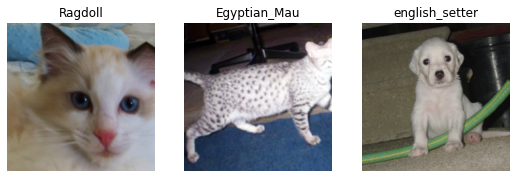

In [9]:
dls.show_batch(nrows=1, ncols=3)

In [10]:
learn = cnn_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.580481,0.403524,0.128552,01:02


epoch,train_loss,valid_loss,error_rate,time
0,0.555652,0.308803,0.097429,01:05
1,0.427592,0.300397,0.087280,01:05
2,0.303998,0.244786,0.074425,01:05
3,0.216292,0.228733,0.067659,01:05


In [11]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics = error_rate).to_fp16()
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.953950,0.301724,0.089310,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.389728,0.298689,0.095399,01:09
1,0.358857,0.287816,0.085250,01:08
2,0.203282,0.209487,0.062246,01:08
3,0.112840,0.179827,0.057510,01:09


In [12]:
x,y = dls.one_batch()

In [13]:
y

TensorCategory([ 9,  8, 36, 13, 15, 36, 22, 14, 20,  5,  6, 31, 21, 31, 15, 34, 31, 16,  4,  0, 17,  5, 25, 11, 28, 25, 35, 11, 21, 28, 26, 36, 12, 32, 23,  3, 17,  6, 34,  5, 21, 20, 30, 16, 19, 16, 27, 33,
        15, 34, 27, 27, 20, 35, 11, 31, 34, 26, 18, 28,  8, 25,  1, 22], device='cuda:0')

In [14]:
preds, som = learn.get_preds(dl = [(x,y)])
preds[0]

tensor([7.6023e-05, 5.0563e-09, 3.2614e-09, 7.4106e-06, 9.2587e-06, 5.5540e-08, 4.6444e-09, 1.0044e-09, 2.2391e-08, 9.9990e-01, 7.3817e-06, 4.3986e-07, 2.6567e-09, 4.5724e-09, 1.0579e-08, 4.5597e-08,
        2.9121e-09, 2.0999e-08, 5.3614e-09, 2.8060e-09, 1.9166e-08, 5.4185e-10, 3.7746e-08, 1.3411e-09, 6.3296e-09, 2.1853e-09, 2.9578e-08, 2.1853e-09, 1.8150e-10, 1.3419e-08, 1.3593e-10, 3.9797e-10,
        2.7303e-09, 1.3706e-07, 5.4201e-08, 4.9925e-09, 1.5889e-08])

In [15]:
som[0]

TensorCategory(9)

A deeper dive into softmax, negative log likelihood and cross entropy loss

In [16]:
# Softmax
p = torch.tensor([[0,1,2], [3,5,2], [1,0,4]]).float()
p
# The first part we want to do is use the softmax, which essentially means transforming each output into probabilities that sum to 1
def my_softmax(x): return torch.exp(x)/ torch.exp(x).sum(dim = 1, keepdim = True)
def my_softmax2(x): return torch.exp(x) / torch.exp(x).sum(dim = 1).view(-1,1)
my_softmax(p), my_softmax2(p)
# The keepdim part here is crucial: if keepdim is false then the .sum returns the row sums but as a 1x3 dim tensor
# PyTorch then uses broadcasting and divides each element by the first, second and third sum respectively which is not what we want
# If the keepdim = True the return of the sum function is a 3x1 tensor and then correctly each element of the first row is divided by the sum of the first row

(tensor([[0.0900, 0.2447, 0.6652],
         [0.1142, 0.8438, 0.0420],
         [0.0466, 0.0171, 0.9362]]), tensor([[0.0900, 0.2447, 0.6652],
         [0.1142, 0.8438, 0.0420],
         [0.0466, 0.0171, 0.9362]]))

In [17]:
# Negative log likelihood
# After we have got probabilities we want to calculate the loss. We calculate those losses based on the correct label and the probability that was assigned to that label
target = torch.tensor([1, 0, 2])
preds = my_softmax(p)
print(preds)
target_probs = preds[range(len(preds)), target] #This part of the code selects the probability corresponding to the correct label
print(target_probs)
-torch.log(target_probs) # The smaller our probability the biggest the loss (if we predict 1 the loss will be 0)

tensor([[0.0900, 0.2447, 0.6652],
        [0.1142, 0.8438, 0.0420],
        [0.0466, 0.0171, 0.9362]])
tensor([0.2447, 0.1142, 0.9362])


tensor([1.4076, 2.1698, 0.0659])

In [18]:
F.log_softmax(p, dim = 1) # This Torch function calculates both in one step
F.nll_loss(F.log_softmax(p, dim = 1), target, reduction='none') #!!!!! F.nll_loss does not take the log! it only takes the minus part of the negative log likelihood

tensor([1.4076, 2.1698, 0.0659])

In [19]:
# Cross entropy loss
# This is parts 1&2 together
-torch.log(target_probs).mean()

tensor(1.2144)

In [20]:
#In PyTorch
loss_func = nn.CrossEntropyLoss()
print(loss_func(p, target))
# Or using the functional version
F.cross_entropy(p, target)

tensor(1.2144)


tensor(1.2144)

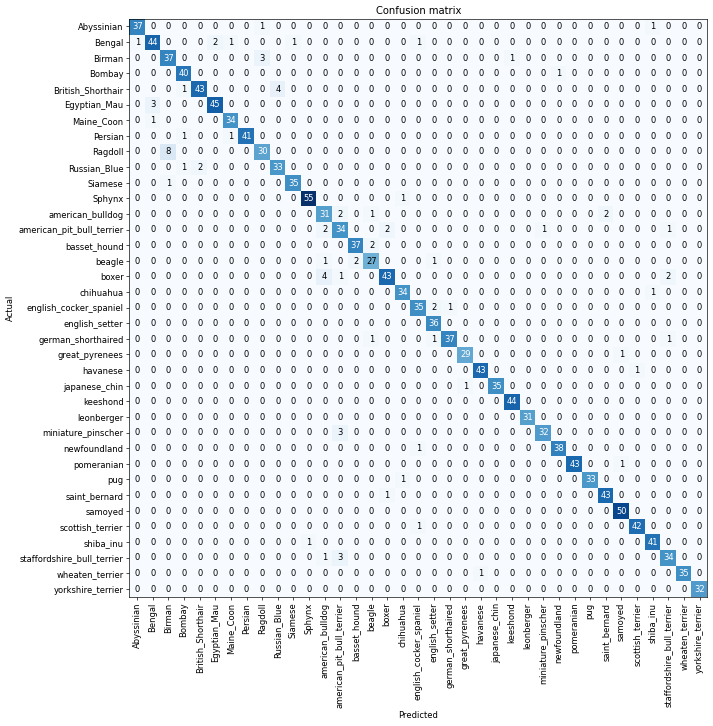

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [22]:
interp.most_confused(min_val = 4)

[('Ragdoll', 'Birman', 8),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('boxer', 'american_bulldog', 4)]

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


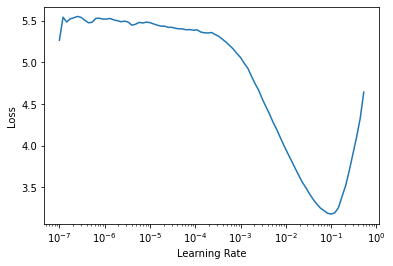

In [23]:
# Learning rate finder
learn = cnn_learner(dls, resnet34, metrics = error_rate)
lr_min, lr_steep = learn.lr_find()

In [24]:
lr_steep, lr_min
# We can try the steepest learning rate and compare it with just the default one (1e-3)

(0.002511886414140463, 0.010000000149011612)

In [25]:
learn = cnn_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.496497,0.334350,0.108931,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.498798,0.313982,0.093369,01:12
1,0.324558,0.233132,0.064276,01:12


In [26]:
learn = cnn_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(2, base_lr = lr_steep)

epoch,train_loss,valid_loss,error_rate,time
0,1.359421,0.311749,0.108931,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.519220,0.317772,0.101489,01:12
1,0.335033,0.233049,0.073072,01:12


In [27]:
learn = cnn_learner(dls, resnet34, metrics = error_rate)
learn.fit_one_cycle(3, 3e-3) #Train the new layer for 3 epochs
learn.unfreeze() #Unfreeze also the previous layers
learn.fit_one_cycle(12, lr_max = slice(1e-6, 1e-4)) #train the whole model for 12 epochs with varying learning rate

epoch,train_loss,valid_loss,error_rate,time
0,1.122493,0.357285,0.117050,01:07
1,0.533946,0.260364,0.086604,01:07
2,0.331619,0.211250,0.064276,01:08


epoch,train_loss,valid_loss,error_rate,time
0,0.274210,0.206134,0.062246,01:12
1,0.260684,0.201574,0.062246,01:13
2,0.246032,0.187572,0.056157,01:12
3,0.217260,0.191508,0.061570,01:12
4,0.197460,0.189847,0.059540,01:12
5,0.174606,0.188988,0.060893,01:12
6,0.166921,0.176011,0.056834,01:12
7,0.144854,0.179015,0.056834,01:12
8,0.151787,0.174290,0.053451,01:12
9,0.138666,0.171627,0.054804,01:12
